# Persistent Cohomology and Circular Coordinates

Following the work in [dS-M-VJ], this document demonstrates how - concretely - to compute circular coordinates using persistent cohomology. We will be using [Dionysus 2](http://www.mrzv.org/software/dionysus2/) and the SciPy / PyLab stack.

In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


As an example dataset, let's generate some points on the Lorenz dynamical system:

$$
\frac{dx}{dt} = \sigma(y-x)
\quad
\frac{dy}{dt} = x(\rho-z)-y
\quad
\frac{dz}{dt} = xy-\beta z
$$

with Lorenz' parameter values $\sigma=10, \rho=28, \beta=8/3$.

In [38]:
import scipy.integrate

sigma = 10.
rho = 28.
beta = 8/3

def f(state, t):
    (x,y,z) = state
    return (sigma*(y-x), x*(rho-z)-y, x*y-beta*z)

ts = arange(0,40,0.025)
states = scipy.integrate.odeint(f, (1.,1.,1.), ts)
lorenz = states[-800:,:]

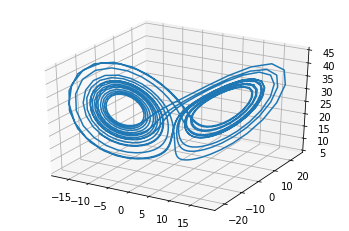

In [59]:
from mpl_toolkits.mplot3d import Axes3D

subplot(111, projection="3d")
plot(*lorenz.T)

To produce a nicer example, I skipped a burnin period of about 2k samples from the Lorenz system before gathering 2k points.

Now, using Dionysus' support for Vietoris-Rips complexes and cohomology computation. Let's use a large-ish prime as a superstitious ritual to dodge any torsion that would derail the coordinate computation.

In [43]:
prime = 11
vr = dionysus.fill_rips(lorenz, 2, 10.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

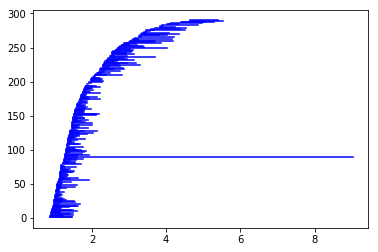

In [44]:
dionysus.plot.plot_bars(dgms[1], show=True)

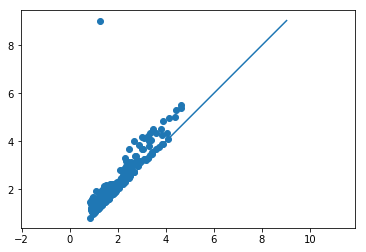

In [45]:
dionysus.plot.plot_diagram(dgms[1], show=True)

We see one long bar, one point out from the diagonal (or at least what looks like one). We can check concretely to see how many non-noise classes this has found for us:

In [47]:
bars = [bar for bar in dgms[1] if bar.death > 8]
bars

[(1.27536,9.02693), (2.28555,inf)]

Like we might expect, this produces two cohomology classes with very large persistence. We will pick out their cocycles, and pick one specific complex over which to smooth the cocycles out to form a coordinate function.

We could pull out the information needed for the smoothing from the cocycles, as well as the boundary matrix for the complex we choose, and run the LSQR optimization ourselves - but `Dionysus` implements the entire process.

In [48]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 8.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]


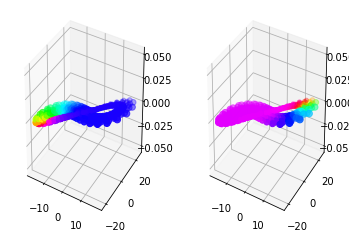

In [61]:
subplot(121, projection="3d")
scatter(*lorenz.T, c=coords[0], cmap="hsv")

subplot(122, projection="3d")
scatter(*lorenz.T, c=coords[1], cmap="hsv")

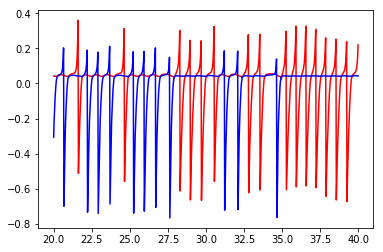

In [64]:
plot(ts[-len(coords[0]):], coords[0], 'r')
plot(ts[-len(coords[1]):], coords[1], 'b')

# Existing directions

This notebook reproduces one of the examples in [dS-VJ-M] - since then, further research has been using circular coordinates for other time series applications. Notably: 

* [B-G-VJ] used k-means on persistent cohomology to locate bifurcations and classify the intermediate regions
* [VJ-P-S-K] used persistent cohomology to produce intrinsic phase coordinates for motion capture data, which in turn allows both for generating intrinsically loopable mean motion motifs, and allows for detecting distinct modes of motion.


# References 

* ds-VJ-M: de Silva V, Morozov D, Vejdemo-Johansson M. Persistent cohomology and circular coordinates. Discrete & Computational Geometry. 2011 Jun 1;45(4):737-59.
* B-G-VJ: Berwald J, Gidea M, Vejdemo-Johansson M. Automatic recognition and tagging of topologically different regimes in dynamical systems. arXiv preprint arXiv:1312.2482. 2013 Dec 9.
* VJ-P-S-K: Vejdemo-Johansson M, Pokorny FT, Skraba P, Kragic D. Cohomological learning of periodic motion. Applicable Algebra in Engineering, Communication and Computing. 2015 Mar 1;26(1-2):5-26.